In [1]:
print('\nCarregando...')

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time



Carregando...


# Importando tabelas e gerando listas

In [2]:
print('Carregando dados...')

df_dados = pd.read_excel('dados.xlsx')
df_fator = pd.read_excel('config.xlsx', 0)
df_email = pd.read_excel('config.xlsx', 1)

lst_meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
lst_meses_dados = ['Dez anterior','Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov']
lst_layout = ['Galpões', 'Complemento','Registro', 'Empresa', 'Tipo de imóvel']
lst_df_empresas = []


Carregando dados...


# Gerando Data Frame das diferenças

In [3]:
df_diferença = df_dados.loc[:, lst_layout]

for m, d in zip(lst_meses, lst_meses_dados):
    dif = df_dados.loc[:, m] - df_dados.loc[:, d]
    df_diferença.loc[:, m] = dif


df_diferença = df_diferença.loc[~df_diferença['Jan'].isna(), :].reset_index(drop=True)

df_fator.loc[3, 'Volume max de água m3'] = 999999


# Definição de funções

In [4]:
# criação de função DataFrame para adição de row TOTAL
def DF_total(df):
    num_index = max(df.index) + 1
    df.loc[num_index,:] = df.sum(numeric_only=True, axis=0)
    df.loc[num_index, 'Galpões'] = 'TOTAL'
    df.loc[df['Galpões'] == 'TOTAL', :].round(2)


# criação de função DataFrame para cada empresa. Obs: a variavel ainda será definida antes do uso
def DF_droper_empresa(df, comp):
    df_temp = df.loc[df['Empresa'] == comp, :].reset_index(drop=True)
    # df_temp = df.loc[df['Empresa'] == comp, ['Galpões','Complemento','Registro']+lst_meses_uteis].reset_index(drop=True)
    # df_temp = df_temp.dropna(how='all', axis=1)
    return df_temp


# criando função de adição de linhas vazias
def DF_empty_rows_comb(df):
    
    dc_empty = {col: [np.nan for _ in range(1)] for col in df.columns}
    df_empty = pd.DataFrame(dc_empty)
    df_new = pd.concat([df_empty, df, df_empty], axis=0, ignore_index=True)
    return df_new


# Retirando Colunas inutilizadas

In [5]:


# retirando colunas de meses não marcados para consumo de água
df_diferença = df_diferença.dropna(how='all', axis=1).round(2)


# retirando colunas de meses não marcados para leitura do hidrômetro
df_dados = df_dados.dropna(how='all', axis=1).round(2)

# lista com meses completos
lst_meses_uteis = df_diferença.columns.tolist()
for i in ['Galpões', 'Complemento', 'Registro', 'Empresa', 'Tipo de imóvel']:
    lst_meses_uteis.remove(i)


# Gerando Data Frame dos preços

In [6]:
print('Gerando arquivo Tabela.xlsx...')
# retirando informações de poço 
df_preço = df_diferença.loc[df_diferença['Galpões'] != 'Poço', lst_layout]


# calculando e multiplicando o fator para cada diferença. O loop m: meses ; loop type: tipo de imóvel ; loop index: para cada intervalo multiplicador
for m in lst_meses_uteis:
    
    for type in ['Industrial', 'Residencial']:
        df_preço.loc[(df_diferença[m] < df_fator.loc[0,'Volume max de água m3']) & (df_diferença['Tipo de imóvel'] == type), m] = df_fator.loc[0, f'Fator {type}']
        
        for index in range(1, 4):
            df_preço_temp = df_diferença.loc[(df_diferença[m] < df_fator.loc[index,'Volume max de água m3']) & (df_diferença['Tipo de imóvel'] == type) & (df_diferença[m] >= df_fator.loc[index, 'Volume min de água m3']), m]  
            df_preço.loc[(df_diferença[m] < df_fator.loc[index,'Volume max de água m3']) & (df_diferença['Tipo de imóvel'] == type) & (df_diferença[m] >= df_fator.loc[index, 'Volume min de água m3']), m] = df_preço_temp * df_fator.loc[index, f'Fator {type}']


# retirando colunas de meses não marcados
df_preço = df_preço.dropna(how='all', axis=1)

# TOTAL
DF_total(df_preço)
df_preço = df_preço.round(2)


Gerando arquivo Tabela.xlsx...


# Formatação e geração de arquivo Tabela.xlsx

In [7]:


# formatação R$ em um novo DataFrame
df_preço_formatado = df_preço.loc[:,:]
df_preço_formatado[lst_meses_uteis] = df_preço_formatado[lst_meses_uteis].map(lambda x: f'R$ {x}')
df_preço_formatado.loc[max(df_preço_formatado.index) + 2,'Galpões'] = 'V1.0 07/2024 by Gian Gabriel Silva Vianna'

# formatação m3 em um novo DataFrame
df_diferença_formatado = df_diferença.loc[:,:]
df_diferença_formatado = df_diferença_formatado.round(2)
df_diferença_formatado[lst_meses_uteis] = df_diferença_formatado[lst_meses_uteis].map(lambda x: f'{x}')
df_diferença_formatado.loc[max(df_diferença_formatado.index) + 2,'Galpões'] = 'V1.0 07/2024 by Gian Gabriel Silva Vianna'

# criação de arquivo excel
with pd.ExcelWriter("Tabela.xlsx", engine="openpyxl") as writer:
    df_preço_formatado.to_excel(writer, sheet_name="Custo água", index=False)

# criação de arquivo excel
with pd.ExcelWriter("Tabela.xlsx", engine="openpyxl", mode="a") as writer:
    df_diferença_formatado.to_excel(writer, sheet_name="Consumo água em m³", index=False)
    

# Separando arquivos na pasta compartilhamento por empresa

In [8]:
# if not os.path.exists(r'compartilhamento'):
#     os.mkdir(r'compartilhamento')


# lista de empresas
lst_empresa = df_preço['Empresa'].value_counts().index.tolist()


for comp in lst_empresa:

    # criação de DataFrame do custo $ para cada empresa
    # criação de DataFrame do consumo m3 para cada empresa
    # criação de DataFrame do registro para cada empresa
    df_preço_temp = DF_droper_empresa(df_preço, comp)
    df_diferença_temp = DF_droper_empresa(df_diferença, comp)
    df_dados_temp = DF_droper_empresa(df_dados, comp)
    
    # implementação de TOTAL para custo $
    # implementação de TOTAL para consumo m3
    if max(df_preço_temp.index) > 0:
        DF_total(df_preço_temp)
    if max(df_diferença_temp.index) > 0:
        DF_total(df_diferença_temp)
    
    # formatação de R$
    # formatação de m3
    df_preço_temp[lst_meses_uteis] = df_preço_temp[lst_meses_uteis].map(lambda x: f'R$ {round(x, 2)}')
    df_diferença_temp[lst_meses_uteis] = df_diferença_temp[lst_meses_uteis].map(lambda x: f'{x:.1f}')

    

    # empty rows
    df_dados_temp = DF_empty_rows_comb(df_dados_temp)
    df_diferença_temp = DF_empty_rows_comb(df_diferença_temp)
    df_preço_temp = DF_empty_rows_comb(df_preço_temp)
    # informações de cada tabela
    df_dados_temp.loc[0,'Galpões'] = 'LEITURA'
    df_preço_temp.loc[0,'Galpões'] = 'CUSTO'
    df_diferença_temp.loc[0,'Galpões'] = 'CONSUMO '
    
    
    # combinando DataFrames
    df_final_formatado_temp = pd.concat([df_dados_temp, df_diferença_temp, df_preço_temp], axis=0, ).reset_index(drop=True).dropna(how='all', axis=1)
    
    df_final_formatado_temp = df_final_formatado_temp.drop(max(df_final_formatado_temp.index) ,axis=0)
    
    # geração de arquivo excel
    # df_final_formatado_temp.to_excel(fr'compartilhamento\{comp}.xlsx', index=False)

    df_final_formatado_temp = df_final_formatado_temp.fillna('')
    
    # adicionando DataFrames para uma lista
    lst_df_empresas.append(df_final_formatado_temp)
    

# Gerando gráficos internos 
(Consumo de água x mês)

In [9]:
# # Gerando figura com gráficos da diferença 
# fig_int = plt.figure(figsize=(30,80))
# fig_int.suptitle('Gráficos consumo por mês de cada galpão/ casa/ poço')




# Gerando gráficos individuais com tabelas em pdf para cada empresa

# Importando bibliotecas

In [10]:
print('Gerando arquivos pdf...')

from reportlab.lib.pagesizes import landscape, A4, A3
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Image, Spacer
from reportlab.lib import colors
from reportlab.lib.units import inch
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import Paragraph
from reportlab.pdfgen import canvas
import io

if not os.path.exists(r'compartilhamento pdf'):
    os.mkdir(r'compartilhamento pdf')

Gerando arquivos pdf...


In [11]:
class FooterDocTemplate(SimpleDocTemplate):
    def __init__(self, *args, **kwargs):
        self.footer_text = kwargs.pop('footer_text', '')
        SimpleDocTemplate.__init__(self, *args, **kwargs)
    
    def afterFlowable(self, flowable):
        if self.canv.getPageNumber() == 1:
            self._draw_footer()
    
    def _draw_footer(self):
        self.canv.saveState()
        self.canv.setFont('Helvetica', 15)
        width, height = self.pagesize
        self.canv.drawString(inch, 0.5 * inch, self.footer_text)
        self.canv.restoreState()

# Enviar emails

<Figure size 640x480 with 0 Axes>

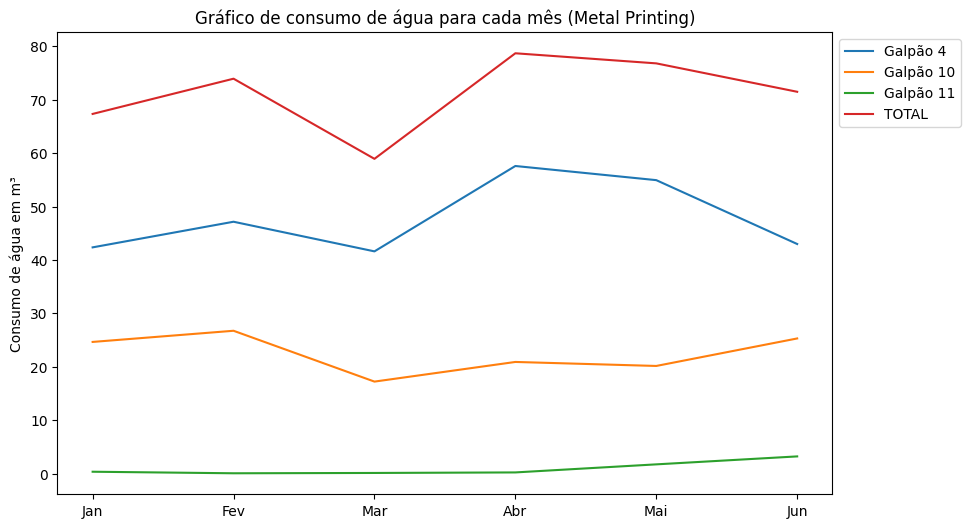

<Figure size 640x480 with 0 Axes>

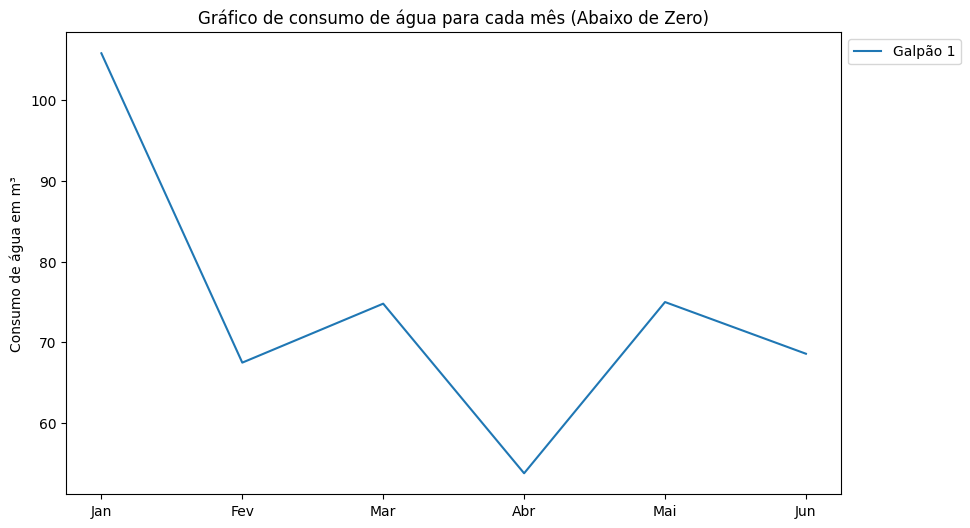

<Figure size 640x480 with 0 Axes>

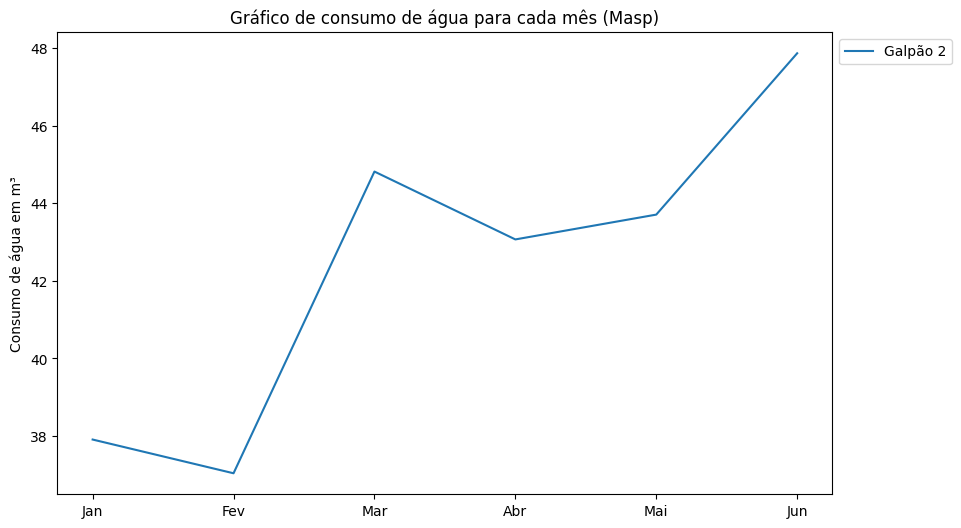

<Figure size 640x480 with 0 Axes>

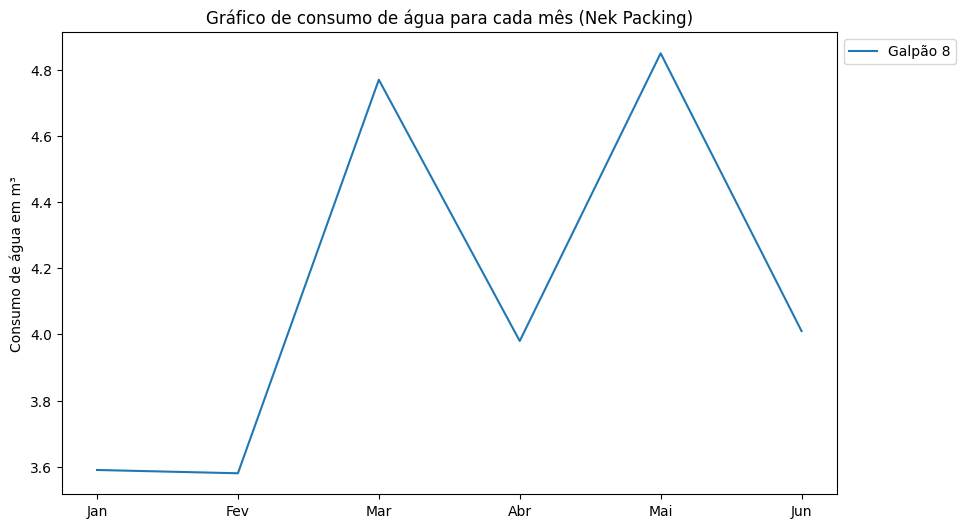

In [12]:
for df, comp in zip(lst_df_empresas, lst_empresa):
    
    df = df.drop(['Tipo de imóvel', 'Empresa'], axis=1)

    # DataFrame importante
    df_para_grafico = DF_droper_empresa(df_diferença, comp)
    df_para_grafico = df_para_grafico.drop(['Registro', 'Complemento', 'Empresa', 'Tipo de imóvel'], axis=1)

    # Empresas que possuem mais de um galpão visualizarão somente o gráfico total
    if max(df_para_grafico.index) > 0:
        DF_total(df_para_grafico)
        # df_para_grafico = df_para_grafico.loc[df_para_grafico['Galpões'] == 'TOTAL', :]
        



    
    
    df_para_grafico.index = df_para_grafico.loc[:, 'Galpões'].tolist()
    df_para_grafico = df_para_grafico.drop('Galpões', axis=1)
    df_para_grafico = df_para_grafico.T
    df_para_grafico.index = range(len(lst_meses_uteis))




    # Step 2: Create a graph using Matplotlib
    plt.figure()
    df_para_grafico.plot(kind='line')
    plt.title(f'Gráfico de consumo de água para cada mês ({comp})')
    plt.ylabel('Consumo de água em m³')
    plt.xticks(df_para_grafico.index.tolist(), lst_meses_uteis)

    # Place the legend outside the plot area
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    fig = plt.gcf()
    fig.set_size_inches(10, 6)

    # Save the graph to a BytesIO object
    graph_buffer = io.BytesIO()
    plt.savefig(graph_buffer, format='png', dpi=500)
    graph_buffer.seek(0)
    
    # Step 3: Convert the DataFrame to a table that can be added to the PDF
    data_for_pdf = [df.columns.values.tolist()] + df.values.tolist()

    # Step 4: Create a PDF document
    pdf_buffer = io.BytesIO()
    footer_text = f'Arquivo gerado em: {datetime.now().strftime("%d-%m-%Y %H:%M")}'
    pdf = FooterDocTemplate(
        pdf_buffer, 
        pagesize=landscape(A3),
        leftMargin=0.2 * inch,
        rightMargin=0.2 * inch,
        topMargin=0.2 * inch,
        bottomMargin=0.2 * inch,
        footer_text=footer_text
    )

    elements = []

    # Create the table
    table = Table(data_for_pdf, colWidths=[1.0 * inch] * len(df.columns))
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ]))
    elements.append(table)

    # Add a spacer for better spacing between table and graph
    elements.append(Spacer(1, 0.5 * inch))  # Adjust the space as needed

    # Add the graph image to the PDF
    graph_image = Image(graph_buffer)
    graph_image.drawHeight = 6 * inch
    graph_image.drawWidth = 15 * inch
    elements.append(graph_image)

    

    # Build the PDF
    pdf.build(elements)
    pdf_buffer.seek(0)

    # Save the PDF to a file
    with open(f'compartilhamento pdf\{comp}.pdf', 'wb') as f:
        f.write(pdf_buffer.read())




In [13]:

import smtplib
import email
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
from datetime import datetime

In [14]:
# email e senha para enviar
email_wv = df_email.loc[0, 'email empresa']
password = df_email.loc[0, 'senha']


# lista de informações sobre as Empresas
lst_email_empresa = df_email.loc[:, 'Empresa destinatária'].dropna().tolist()
lst_email_email_empresa = df_email.loc[:, 'email empresa'].tolist()
del lst_email_email_empresa[0]


# lista para retorno
lst_email_email_retorno = df_email.loc[:, 'emails de retorno'].dropna().tolist()




    

In [15]:
print('Enviando emails...')
lst_sucesso = []
for comp, ecomp in zip(lst_email_empresa, lst_email_email_empresa):
    lst_temp = []
    lst_temp = [ecomp] + lst_email_email_retorno
    filename = f"compartilhamento pdf\{comp}.pdf"

    corpo_email = f"""
    <p>Segue relatório em anexo.</p>
    <p><b>Favor confirmar o recebimento.</b></p>
    """
    data_envio = datetime.now().strftime("%m-%Y")

    # Create the email message
    msg = MIMEMultipart()
    msg['Subject'] = f"Relatório Consumo Água {data_envio}"
    msg['From'] = email_wv
    msg['To'] = ', '.join(lst_temp)  # Join the list of recipients into a single string

    # Attach the body
    msg.attach(MIMEText(corpo_email, 'html'))  # Specify UTF-8 encoding

    # Attach the file
    with open(filename, "rb") as attachment:
        part = MIMEBase("application", "octet-stream")
        part.set_payload(attachment.read())
        encoders.encode_base64(part)
        part.add_header(
            "Content-Disposition",
            f"attachment; filename= {filename}",
        )
        msg.attach(part)

    # Connect to the SMTP server and send the email
    try:
        s = smtplib.SMTP('smtp.gmail.com', 587)
        s.starttls()
        s.login(email_wv, password)
        s.sendmail(email_wv, lst_temp, msg.as_string().encode('utf-8'))  # Ensure UTF-8 encoding
        lst_sucesso.append(comp)
    except Exception as e:
        print(f"Error: {e}")
    finally:
        s.quit()

if len(lst_sucesso) == len(lst_email_empresa):
    
    time.sleep(1)
    for comp, ecomp in zip(lst_email_empresa, lst_email_email_empresa):
        print(f"Email enviado para {ecomp} ({comp}) com sucesso!")


Enviando emails...


TypeError: sequence item 0: expected str instance, float found